In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, SimpleRNN, GRU
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing

import matplotlib.pyplot as plt
import scipy.stats

In [19]:
df = pd.read_parquet('/content/ES_EFAS-3.5_vs_ENTSOE-INFLOW_2015-2019.parquet')
df

,year,week,entsoe_inflow,time_id,H1005,H101,H1018,H1028,H1031,H1069,...,H857,H859,H86,H873,H887,H925,H948,H953,H967,area
0,2015.0,1.0,708277.0,2015_01,88.069824,28.543945,72.328612,148.275389,116.437987,1.228516,...,32.047363,51.903808,45.742187,73.741211,351.716795,176.342288,31.959961,2.689941,15.527832,ES
1,2015.0,2.0,437008.6,2015_02,82.586915,31.879883,56.786133,115.069825,110.856446,1.334961,...,27.462891,111.692383,68.846192,61.342285,322.716308,184.463380,39.242187,6.717773,15.535156,ES
2,2015.0,3.0,616387.2,2015_03,93.465820,161.380859,50.924805,100.569336,105.182617,1.068848,...,31.662109,211.155762,202.215818,122.646485,307.316895,529.228022,35.625000,64.738281,16.364258,ES
3,2015.0,4.0,813132.2,2015_04,145.741210,101.079101,45.565430,83.609375,99.389648,15.974609,...,59.688477,194.179686,176.407226,149.385742,269.334961,534.017579,30.040039,11.191406,16.106445,ES
4,2015.0,5.0,1122049.2,2015_05,371.128908,181.602539,82.486328,74.779296,142.056639,25.118165,...,224.326172,464.415049,339.549805,291.621094,243.638669,893.672856,27.750977,14.769531,28.443359,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2019.0,48.0,1457445.0,2019_48,301.628907,102.468749,200.983889,283.618162,180.356934,53.066895,...,92.351074,567.508790,323.402344,298.147457,602.676269,1066.965820,65.783203,3.806152,55.051270,ES
257,2019.0,49.0,1364704.0,2019_49,220.569825,54.637207,184.179198,257.837407,141.628419,18.358887,...,69.155762,367.151858,208.076661,219.740724,441.711913,729.397465,62.468263,1.894531,47.236816,ES
258,2019.0,50.0,1675872.0,2019_50,1493.715800,161.245114,271.038572,467.604001,201.033690,184.563965,...,107.643066,889.644055,447.631342,491.168455,545.919926,1438.122570,159.637696,36.238770,40.587402,ES
259,2019.0,51.0,1791601.0,2019_51,859.131830,349.050294,349.508786,577.421400,541.392584,118.244630,...,235.622069,1187.771010,432.675781,425.366210,915.775880,1704.556150,166.396484,62.289550,94.569334,ES


In [20]:
df = df.drop(['area'], axis = 1)

In [21]:
scaler = preprocessing.StandardScaler().fit(df)
df_s = scaler.transform(df)
df_s = pd.DataFrame(df_s, index=df.index, columns=df.columns)

In [26]:
x = np.array(df_s.loc[:,df.columns.str.startswith("H")])
y = np.array(df_s.loc[:, 'entsoe_inflow'])
print(x.shape, y.shape)

(261, 118) (261,)


In [27]:
'''
KFold: This is a class provided by scikit-learn
for performing K-fold cross-validation.
K-fold cross-validation is a technique
used in machine learning to evaluatethe performance of a model.
It involves splitting the dataset into K subsets (or folds) of approximately equal size.
n_splits=5: This parameter specifies the number of folds to create during the cross-validation process. In this case, it's set to 5, meaning the dataset will be split into 5 folds.
shuffle=False: This parameter controls whether the data is shuffled before splitting it into folds. If set to False, the data will not be shuffled, meaning that the order of samples in the dataset will be preserved when creating the folds.
'''
kfold = KFold(n_splits=5, shuffle=False)

In [28]:
'''
After executing this line, cv_out will be a NumPy array filled with zeros, with the same number of rows as the length of y and 2 columns. This array could be used to store some calculated outputs or results during the cross-validation process or any other computation related to the data in y.
'''
cv_out = np.zeros(shape=(len(y),2))

In [29]:
for train, test in kfold.split(y):
    x_train, y_train = x[train,:], y[train]
    x_test, y_test   = x[test,:], y[test]

    # network parameters
    batch_size = 72
    hidden_units = 64
    dropout = 0.2

    model = Sequential()
    model.add(Dense(hidden_units, input_dim = x.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    model.compile(loss='mae',
              optimizer='adam',
              metrics=['RootMeanSquaredError'])

    # train the network
    model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0, validation_split=0.2, callbacks=[stop])

    yhat = model.predict(x_test)
    print(scipy.stats.pearsonr(y_test, yhat.flatten()))

    cv_out[test, 0] = y_test
    cv_out[test, 1] =  yhat.flatten()

Epoch 98: early stopping
2/2 [==============================] - 0s 6ms/step
PearsonRResult(statistic=0.8896532770018982, pvalue=5.404825294042844e-19)
Epoch 98: early stopping
2/2 [==============================] - 0s 7ms/step
PearsonRResult(statistic=0.9039105291221873, pvalue=4.470597267485783e-20)
Epoch 59: early stopping
2/2 [==============================] - 0s 7ms/step
PearsonRResult(statistic=0.8769652617245224, pvalue=1.555703520265191e-17)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.9231546434706489, pvalue=2.110416945379502e-22)
Epoch 55: early stopping
2/2 [==============================] - 0s 6ms/step
PearsonRResult(statistic=0.8503892986023953, pvalue=1.4899350702231956e-15)


PearsonRResult(statistic=0.8692163627655484, pvalue=3.3789981516911054e-81)


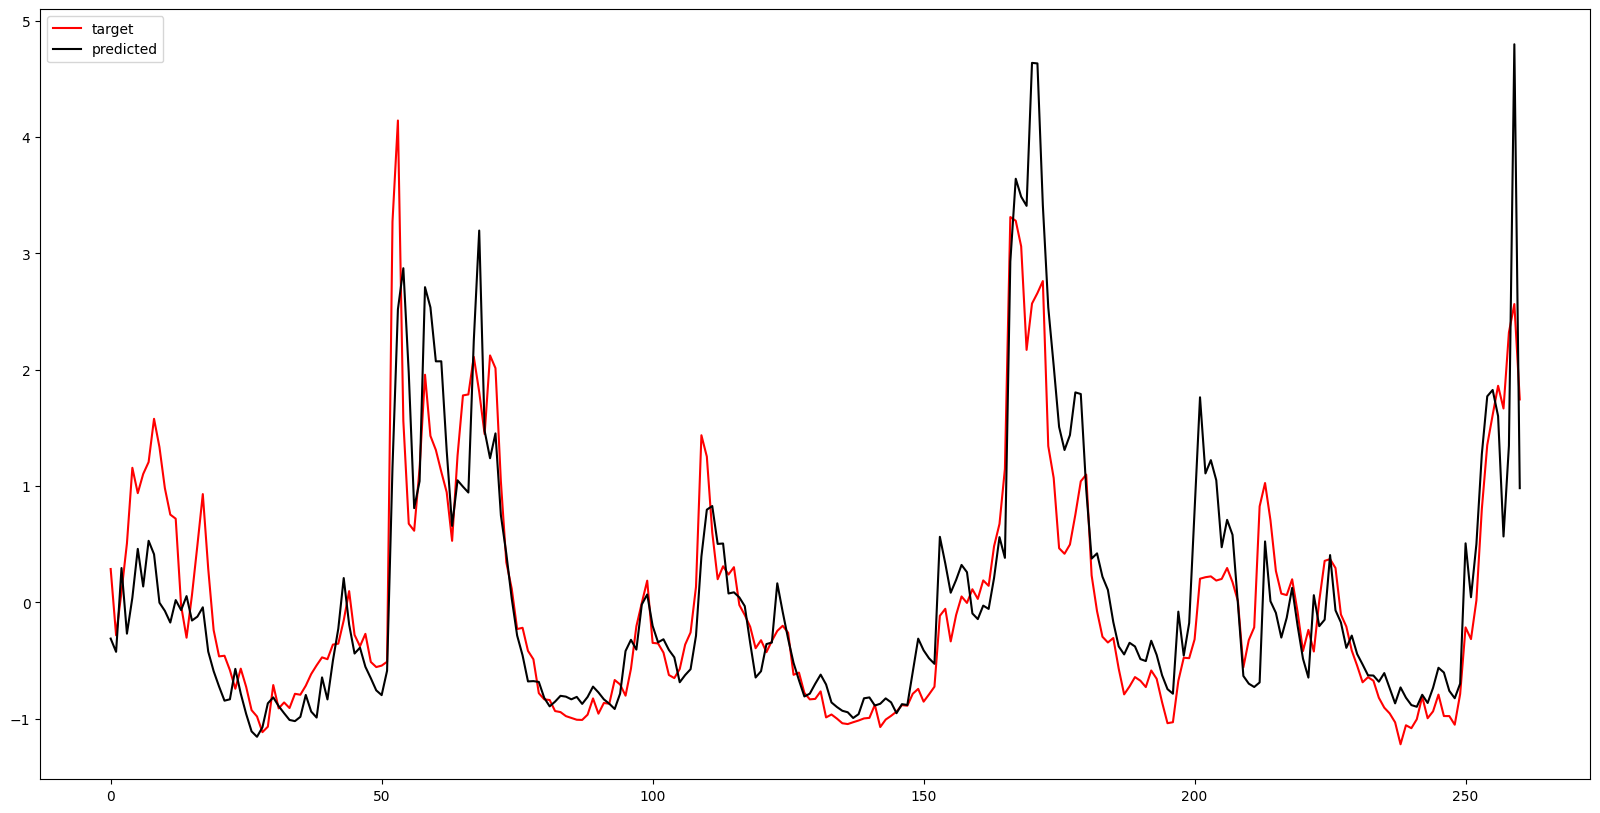

In [30]:
print(scipy.stats.pearsonr(cv_out[:,0], cv_out[:,1]))

plt.figure(figsize=(20,10))
plt.plot(cv_out[:,0], c = 'r', label = 'target') # target
plt.plot(cv_out[:,1], c = 'k', label = 'predicted') # network out
plt.legend(loc="upper left")

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(cv_out[:, 0], cv_out[:, 1])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(cv_out[:, 0], cv_out[:, 1])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.37585829171000434
Mean Squared Error (MSE): 0.2996347531846659
Root Mean Squared Error (RMSE): 0.5473890327588469


In [32]:
import joblib

# Assuming 'model' is your trained neural network model
joblib.dump(model, 'trained_model.h5')


['trained_model.h5']